# Capítulo 8 - BLAST e outras ferramentas de pesquisa de sequências

Identificação de sequências biológicas são uma parte integral da bioinformática. Diversas ferramentas estão disponíveis para isso, cada uma com seus algoritmos e abordagens, como o BLAST (de longe o mais popular), FASTA, HMMER e muito mais. Em geral, essas ferramentas usam a sua sequência para pesquisar potenciais matches no banco de dados. Com o crescimento de sequências conhecidas (logo, aumentando o potencial número de matches), a interpretação dos resultados começa a ficar difícil com as centenas ou milhares de potenciais matches. Naturalmente, a interpretação manual dos resultados de pesquisa está fora de questão. Além disso, você frequentemente precisará trabalhar com diversas ferramentas de sequenciamento, cada uma com suas estatísticas, convensões e formatos de saída. Imagine o quão assustador seria quando você precisar trabalhar com múltiplas sequências usando múltiplas ferramentas.

O pessoal do Biopython sabe muito bem disso como nós, por esse motivo é que foi desenvolvido o módulo `Bio.SearchIO`. Esse módulo permite que você extraia as informações dos resultados de sua pesquisa de um modo conveniente, ao mesmo tempo que lida com os distintos padrões e convensões usados por diferentes ferramentas. O nome **SearchIO** é uma homenagem ao módulo da biblioteca BioPerl de mesmo nome.

Nesse capítulo, vamos ver os principais recursos do `Bio.SearchIO`e mostrar o que cada um pode fazer. Usaremos duas ferramentas bem conhecidas na bioinformática: BLAST e BLAT. Elas estão aqui apenas para fins ilustrativos e você deve ser capaz de adaptar o fluxo de trabalho a qualquer outra ferramenta de pesquisa suportada pelo `Bio.SearchIO`. Você está convidado a acompanhar os exemplos com os arquivos que usamos no capitulo anterior. Ambos os arquivos podem ser encontrados no mesmo repositório que este documento. Ambos os arquivos foram gerados com essa sequência:

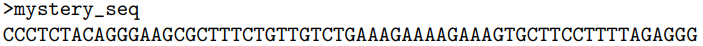

O resultado do BLAST é um arquivo XML usando o **blastn** contra o banco de dados do NCBI **refseq_rna**. Para o BLAT, o banco de dados de sequência usado foi o **hg19** humano de Fevereiro de 2009 e a saída é no formato PSL.

Começaremos com uma introdução ao modelo de objeto `Bio.SearchIO`. O modelo é a representação dos resultados da sua pesquisa, logo, é o centro do próprio `Bio.SearchIO`. Depois disso, checaremos as funções principais do `Bio.SearchIO` que você pode usar com frequência.

Agora que já está tudo explicado, vamos ao primero passo: apresentação do modelo de objeto central.

## 8.1 O modelo de objeto SearchIO

Apesar da grande diferença nos estilos de saída das diversas ferramentas, todas possuem pontos em comum:

- O arquivo de saída deve conter os resultados de uma ou mais consultas de pesquisa;

- Em cada consulta de pesquisa você verá um ou mais resultados do banco de dados de pesquisa fornecido;

- Em cada acerto do banco de dados você verá uma ou mais regiões contendo a atual sequência de alinhamento entre a sua sequência query e a sequência do banco de dados e;

- Alguns programas como o BLAT ou o Exonerate podem dividir ainda mais essas regiões em diversos fragmentos de alinhamentos (ou blocos no BLAT ou possíveis exons no Exonerate). Isso não é um comportamento recorrente, pois ferramentas como BLAST e HMMER não fazem isso.

Percebendo essa generalidade, o Biopython usa isso como base oara criar o modelo de objeto `Bio.SearchIO`. O modelo de objeto consiste em uma hierarquia aninhada de objetos Python, cada um representando um conceito descrito acima. Esses objetos são:

- **QueryResult**: Representa uma única consulta de pesquisa;

- **Hit**: Representa uma única ocorrência no banco de dados. Objetos **Hit** estão contidos em **QueryResult** e em cada **QueryResult** há zero ou mais objetos **Hit**;

- **HSP** (sigla para *high-scoring-pair*): Representa a(s) região(ões) de alinhamentos significativos entre a sequência de consulta e as sequências de acerto. Objetos **HSP** estão condidos em objetos **Hit** e cada objeto **Hit** tem um ou mais objetos **HSP** e;

- **HSPFragment**: Representa um único alinhamento contíguo entre as sequências de consulta e a de acerto. Objetos **HSPFragment** estão contidos em objetos **HSP**. Muitas ferramentas como BLAST e HMMER unificam os objetos **HSP** e **HSPFragment**, pois cada **HSP** terá um único **HSPFragment**. Contudo, há ferramentas como BLAT e Exonerate que produzem **HSP** com múltiplos **HSPFragment**. Mas não se preocupe se isso parece um pouco confuso agora, vamos falar mais desses dois objetos no decorrer do capítulo.

Estes quatro objetos são aqueles que você irá interagir quando usar o `Bio.SearchIO`. Eles são criados usando um dos métodos principais do `Bio.SearchIO`: **read**, **parse**, **index** ou **index_db**. Os detalhes desses métodos serão providenciados nas seções seguintes. Para essa seção, usaremos apenas o **read** e **parse**. Esses métodos funcionam como as suas contrapartes em `Bio.SeqIO` e `Bio.AlignIO`:

- **read**: Usado para arquivos de saída que possuam somente uma consulta e retorna um objeto **QueryResult** e;

- **parse**: Usado para arquivos com múltiplas consultas e retorna um gerador que produz objetos **QueryResult**.

Com isso resolvido, vamos começar a analisar cada objeto `Bio.SearchIO`; começanco com o **QueryResult**.

### 8.1.1 QueryResult

O objeto **QueryResult** representa uma única consulta de pesquisa e contém zero ou mais objetos **Hit**. Vamos ver como ele se parece usando o arquivo BLAST:

In [1]:
from Bio import SearchIO
qresultado_blast = SearchIO.read('meu_blast.xml', 'blast-xml')
print(qresultado_blast)

Program: blastn (2.2.27+)
  Query: 42291 (61)
         mystery_seq
 Target: refseq_rna
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0      1  gi|262205317|ref|NR_030195.1|  Homo sapiens microRNA 52...
            1      1  gi|301171311|ref|NR_035856.1|  Pan troglodytes microRNA...
            2      1  gi|270133242|ref|NR_032573.1|  Macaca mulatta microRNA ...
            3      2  gi|301171322|ref|NR_035857.1|  Pan troglodytes microRNA...
            4      1  gi|301171267|ref|NR_035851.1|  Pan troglodytes microRNA...
            5      2  gi|262205330|ref|NR_030198.1|  Homo sapiens microRNA 52...
            6      1  gi|262205302|ref|NR_030191.1|  Homo sapiens microRNA 51...
            7      1  gi|301171259|ref|NR_035850.1|  Pan troglodytes microRNA...
            8      1  gi|262205451|ref|NR_030222.1|  Homo sapien

Nós apenas começamos a ver a ponta do iceberg do modelo de objeto, mas já temos algumas informações importantes. Usando o **print** no objeto **QueryResult** você pode ver:

- O nome do programa e versão (blastn versão 2.2.27+);

- O ID da consulta, descrição e comprimento da sequência (o ID é 42291, a descrição é "mystery_seq" e o comprimento da sequência é de 61 nucleotídeos;

- O banco de dados alvo que a pesquisa foi feita (refseq_rna) e;

- Uma visão geral rápida dos acessos resultantes. Para a nossa sequência de consulta, há 100 resultados potenciais (numerados de 0 a 99 na tabela). Para cada acerto, também podemos ver quantos HSPs existem, seu ID e um trecho da sua descrição. Note aqui que `Bio.SearchIO` trunca a visão geral da tabela de acertos, apenas mostrando as linhas 0 a 27 e 97 a 99.

Agora vamos checar os resultados do arquivo do BLAT usando o mesmo código acima:

In [2]:
from Bio import SearchIO
qresultado_blat = SearchIO.read('meu_blat.psl', 'blat-psl')
print(qresultado_blat)

Program: blat (<unknown version>)
  Query: mystery_seq (61)
         <unknown description>
 Target: <unknown target>
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0     17  chr19  <unknown description>


Você percebeu de cara que tem algumas diferenças. Algumas delas são causadas pelo jeito que o formato PSL armazena os detalhes, como você verá. O restante das diferenças são causadas pelo programa e o banco de dados alvo entre as pesquisas BLAST e BLAT:

- O nome do programa e a versão. `Bio.SearchIO` sabe que o programa é BLAT, mas no arquivo de saída não há informações sobre a versão do programa, então o padrão é versão desconhecida;

- O ID da consulta, descrição e comprimento da sequência. Note aqui que essas informações são ligeiramente diferentes do arquivo BLAST. O ID é "mystery_seq" ao invés do 42991, não há descrição alguma, mas o comprimento da sequência continua com o valor de 61. Esta é, na verdade, uma diferença introduzida pelos próprios formatos de arquivo. Algumas vezes o BLAST cria o seu próprio ID de consulta e usa o ID original para a descrição da sequência;

- O banco de dados alvo para a pesquisa não é conhecido, como não é indicado no arquivo de saída BLAT;

- E finalmente, a lista de acessos é completamente diferente. Aqui podemos ver que a nossa sequência de consulta atinge apenas a entrada do banco de dados *chr19*, mas apresenta 17 regiões HSP. No entanto, isso não deve ser surpreendente, uma vez que estamos usando uma ferramenta diferente, cada um com o seu próprio banco de dados de destino.

Todos os detalhes que você viu quando chamou o método **print** pode ser acessado usando a notação de acesso de um atributo Python. Existem também outros formatos específicos de atributos que você pode acessar usando esse mesmo método:

In [3]:
print(qresultado_blast.program, qresultado_blast.version)

blastn 2.2.27+


In [4]:
print(qresultado_blat.program, qresultado_blat.version)

blat <unknown version>


In [5]:
qresultado_blast.param_evalue_threshold  # exclusivo de blast-xml

10.0

Para uma lista completa dos atributos acessíveis, você pode acessar a documentação online do BLAST (https://biopython.org/docs/1.79/api/Bio.SearchIO.BlastIO.html) e do BLAT(https://biopython.org/docs/1.79/api/Bio.SearchIO.BlatIO.html).

Depois de usar o **print** nos objetos **QueryResult**, vamos avançar mais. O que exatamente é um **QueryResult**? Em termos de objetos Python, **QueryResult** é um híbrido entre uma lista e um dicionário. Em outras palavras, é um objeto que contém todos os recursos convenientes de listas e dicionários.

Assim como as listas e dicionários Python, objetos **QueryResult** também é iterável. Cada iteração retorna um objeto **Hit**:

In [6]:
for hit in qresultado_blast:
    print(hit)

Query: 42291
       mystery_seq
  Hit: gi|262205317|ref|NR_030195.1| (61)
       Homo sapiens microRNA 520b (MIR520B), microRNA
 HSPs: ----  --------  ---------  ------  ---------------  ---------------------
          #   E-value  Bit score    Span      Query range              Hit range
       ----  --------  ---------  ------  ---------------  ---------------------
          0   4.9e-23     111.29      61           [0:61]                 [0:61]
Query: 42291
       mystery_seq
  Hit: gi|301171311|ref|NR_035856.1| (60)
       Pan troglodytes microRNA mir-520b (MIR520B), microRNA
 HSPs: ----  --------  ---------  ------  ---------------  ---------------------
          #   E-value  Bit score    Span      Query range              Hit range
       ----  --------  ---------  ------  ---------------  ---------------------
          0   1.7e-22     109.49      60           [1:61]                 [0:60]
Query: 42291
       mystery_seq
  Hit: gi|270133242|ref|NR_032573.1| (85)
       Macaca m

Para checar quantos itens há (hits) em um **QueryResult**, você pode chamar o método **len** de Python:

In [7]:
len(qresultado_blast)

100

In [8]:
len(qresultado_blat)

1

Assim como nas listas Python, você pode recuperar itens (hits) de um **QueryResult** usando a notação de fatiamento:

In [9]:
qresultado_blast[0]  # recupera o primeiro item

Hit(id='gi|262205317|ref|NR_030195.1|', query_id='42291', 1 hsps)

In [10]:
qresultado_blast[-1]  # recupera o último item

Hit(id='gi|397513516|ref|XM_003827011.1|', query_id='42291', 1 hsps)

Para recuperar vários hits, você pode fatiar os objetos **QueryResult** usando a notação de fatiamento. Nesse caso, será retornado um novo objeto **QueryResult** contendo somente os hits fatiados:

In [11]:
blast_fatiado = qresultado_blast[:3]  # fatia os três primeiros hits
print(blast_fatiado)

Program: blastn (2.2.27+)
  Query: 42291 (61)
         mystery_seq
 Target: refseq_rna
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0      1  gi|262205317|ref|NR_030195.1|  Homo sapiens microRNA 52...
            1      1  gi|301171311|ref|NR_035856.1|  Pan troglodytes microRNA...
            2      1  gi|270133242|ref|NR_032573.1|  Macaca mulatta microRNA ...


Assim como dicionários Python, você pode recuperar os hits usando o ID do mesmo. Isso é muito útil se você sabe o ID do hit nos resultados de uma consulta de pesquisa:

In [12]:
qresultado_blast['gi|262205317|ref|NR_030195.1|']

Hit(id='gi|262205317|ref|NR_030195.1|', query_id='42291', 1 hsps)

Você também pode ter uma lista completa dos objetos **Hit** usando o método **hit** e uma lista completa dos IDs com **hit_keys**:

In [13]:
qresultado_blast.hits

[Hit(id='gi|262205317|ref|NR_030195.1|', query_id='42291', 1 hsps),
 Hit(id='gi|301171311|ref|NR_035856.1|', query_id='42291', 1 hsps),
 Hit(id='gi|270133242|ref|NR_032573.1|', query_id='42291', 1 hsps),
 Hit(id='gi|301171322|ref|NR_035857.1|', query_id='42291', 2 hsps),
 Hit(id='gi|301171267|ref|NR_035851.1|', query_id='42291', 1 hsps),
 Hit(id='gi|262205330|ref|NR_030198.1|', query_id='42291', 2 hsps),
 Hit(id='gi|262205302|ref|NR_030191.1|', query_id='42291', 1 hsps),
 Hit(id='gi|301171259|ref|NR_035850.1|', query_id='42291', 1 hsps),
 Hit(id='gi|262205451|ref|NR_030222.1|', query_id='42291', 1 hsps),
 Hit(id='gi|301171447|ref|NR_035871.1|', query_id='42291', 2 hsps),
 Hit(id='gi|301171276|ref|NR_035852.1|', query_id='42291', 1 hsps),
 Hit(id='gi|262205290|ref|NR_030188.1|', query_id='42291', 1 hsps),
 Hit(id='gi|301171354|ref|NR_035860.1|', query_id='42291', 1 hsps),
 Hit(id='gi|262205281|ref|NR_030186.1|', query_id='42291', 1 hsps),
 Hit(id='gi|262205298|ref|NR_030190.1|', query_i

In [14]:
qresultado_blast.hit_keys

['gi|262205317|ref|NR_030195.1|',
 'gi|301171311|ref|NR_035856.1|',
 'gi|270133242|ref|NR_032573.1|',
 'gi|301171322|ref|NR_035857.1|',
 'gi|301171267|ref|NR_035851.1|',
 'gi|262205330|ref|NR_030198.1|',
 'gi|262205302|ref|NR_030191.1|',
 'gi|301171259|ref|NR_035850.1|',
 'gi|262205451|ref|NR_030222.1|',
 'gi|301171447|ref|NR_035871.1|',
 'gi|301171276|ref|NR_035852.1|',
 'gi|262205290|ref|NR_030188.1|',
 'gi|301171354|ref|NR_035860.1|',
 'gi|262205281|ref|NR_030186.1|',
 'gi|262205298|ref|NR_030190.1|',
 'gi|301171394|ref|NR_035865.1|',
 'gi|262205429|ref|NR_030218.1|',
 'gi|262205423|ref|NR_030217.1|',
 'gi|301171401|ref|NR_035866.1|',
 'gi|270133247|ref|NR_032574.1|',
 'gi|262205309|ref|NR_030193.1|',
 'gi|270132717|ref|NR_032716.1|',
 'gi|301171437|ref|NR_035870.1|',
 'gi|270133306|ref|NR_032587.1|',
 'gi|301171428|ref|NR_035869.1|',
 'gi|301171211|ref|NR_035845.1|',
 'gi|301171153|ref|NR_035838.1|',
 'gi|301171146|ref|NR_035837.1|',
 'gi|270133254|ref|NR_032575.1|',
 'gi|262205445

**pag 139**